<h1 align="center">ECE 176 Project</h1>

# Table of Contents

1. Dataset Preparation: we will implement an American Sign Language (ASL) alphabet library.
2. Model: create a neural network architecture for our dataset.
3. Finetuning: find ways to improve the model.
4. Test/Visuals: create tests and look at which ASL letters were best recognized and why.
5. Conclusion/Discussion: discussion of results and possible further study.



## Acknowledgements
https://www.kaggle.com/grassknoted/aslalphabet_akash nagaraj_2018,
#### ASL Alphabet
https://www.kaggle.com/dsv/29550
10.34740/KAGGLE/DSV/29550


# Dataset Preparation

Initially, we will focus on implementing an American Sign Language (ASL) alphabet library. This involves loading the ASL alphabet dataset, a step that may require a few minutes upon the first attempt. Subsequently, the data will be cached, ensuring quicker access in future sessions. 


In [95]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

# ensure consistency across runs
from numpy.random import seed
import numpy as np
from torch.utils.data import DataLoader, random_split


### CustomImageDataset
Using the pytorch example and taking inspiration from previous assignment, below is the class created for uploading the training and testing datasets to pytorch.

In [96]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()


    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path).convert('RGB')  # Use PIL to open image
        if self.transform:
            image = self.transform(image)
        if self.target_transform and label is not None:
            label = self.target_transform(label)
        return image, label
    
class CustomImageDatasetSkele(Dataset):
    def __init__(self, img_dir, skeleton_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.skeleton_dir = skeleton_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()

    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        full_img_path = os.path.join(self.img_dir, img_path)
        skeleton_path = os.path.join(self.skeleton_dir, img_path)  # Adjust if the structure is different

        image = Image.open(full_img_path).convert('RGB')
        skeleton = Image.open(skeleton_path).convert('L')
        
        # Stack the grayscale image as an additional channel to create a 4-channel image
        combined_image = Image.merge("RGBA", image.split() + (skeleton,))

        if self.transform:
            combined_image = self.transform(combined_image)

        if self.target_transform and label is not None:
            label = self.target_transform(label)

        return combined_image, label

# Default Training/Test Set

Below is a list of the directories used for storing the datasets.

In [98]:
### User, Yann or Sebastian ###

image_size = (200,200)

username = input("Yann or Sebastian? Enter your name as seen here")
print('You are currently in', username,'s path')

if username == 'Yann':
    img_directory='/home/ybaglinbunod/private/unchanged_train/asl_alphabet_train/asl_alphabet_train'
    img_directory2='/home/ybaglinbunod/private/unchanged_train/asl_alphabet_test/asl_alphabet_test'
    img_dir='/home/ybaglinbunod/private/unchanged_test'
    img_skeleton='/home/ybaglinbunod/private/skeletonfolder/skeletonimages'
else:
    img_directory='/home/sdcastaneda/private/asl_alphabet_train/asl_alphabet_train'
    img_directory2='/home/sdcastaneda/private/asl_alphabet_test/asl_alphabet_test'
    
print(img_directory)
###############################



Yann or Sebastian? Enter your name as seen hereYann
You are currently in Yann s path
/home/ybaglinbunod/private/unchanged_train/asl_alphabet_train/asl_alphabet_train


## New Test Set

this transforms all of our training and testing datasets to tensors.

In [99]:
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])





In [100]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Create data loaders for the training and validation sets
train_datasetskeleton = CustomImageDatasetSkele(
    img_dir= img_directory, 
    skeleton_dir = img_skeleton,
    #skeleton_dir ='/home/sdcastaneda/skeleton/skeletonimages',
    transform=train_transform,
    mode='train'
)

transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
dataset = CustomNewImageDataset(img_dir=img_dir, transform=transform)

# Calculate the sizes for training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_data, test_data = random_split(train_datasetskeleton, [train_size, val_size])




## Testing image dataset
###Below is a list of the images from the test dataset

In [101]:
# write code for displaying the test images here:

# Testing
#for i in range(0, len(dataset), 30):  # Adjust step to 30 to get one image per class
#    image, label = dataset[i]
#    image = transforms.ToPILImage()(image)
#    plt.imshow(image)
#    plt.title(f'Label: {label}')
#    plt.axis('off')  # This hides the axis ticks and labels
#    plt.show()
#    
#for i in range(len(dataset)):
#    image, label = dataset[i]
#    if image.size(1) != 200 or image.size(2) != 200:
#        print(f"Image {i} has a different size: {image.size()}")

## Training Dataset

#### Train Dataset has a length of 87,000 images
#### These images are 200x200, 29 classes, 26 for A-Z 3 for SPACE, DELETE, and NOTHING


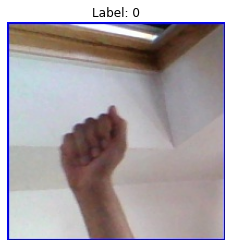

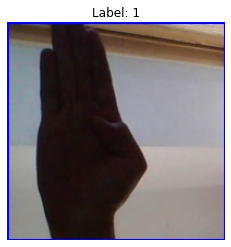

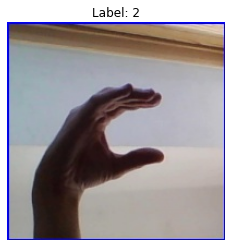

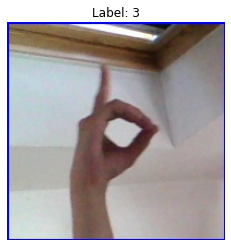

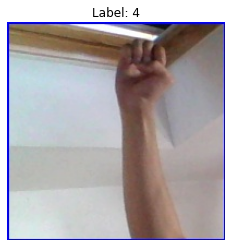

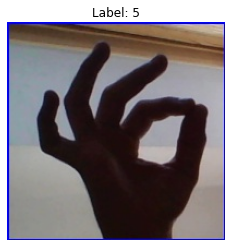

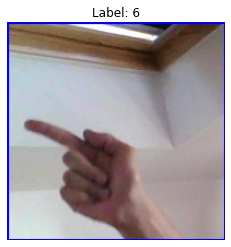

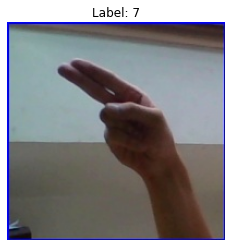

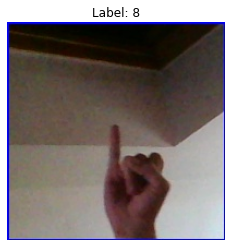

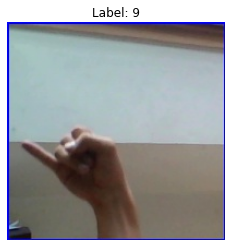

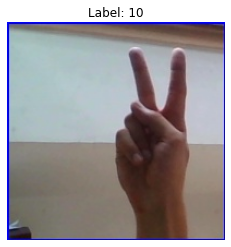

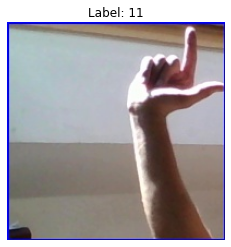

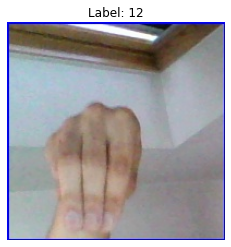

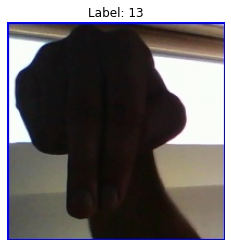

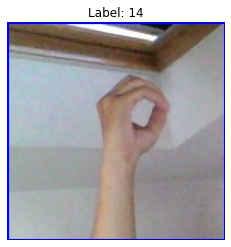

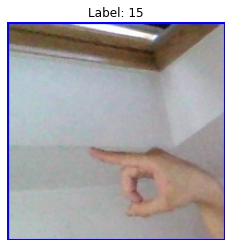

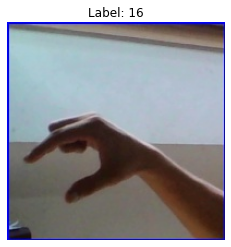

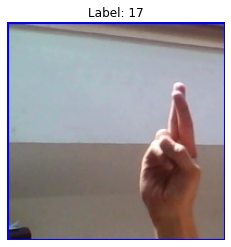

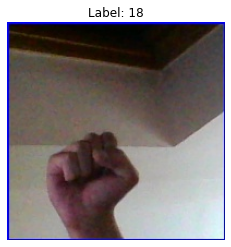

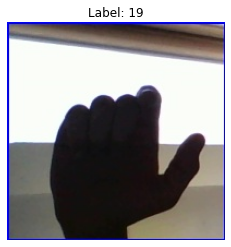

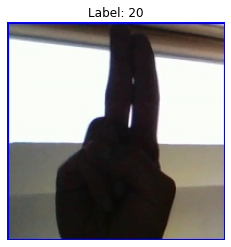

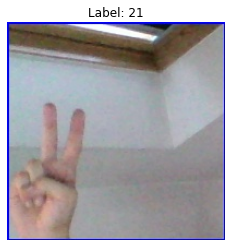

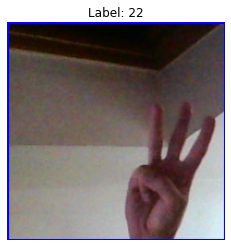

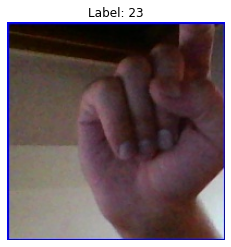

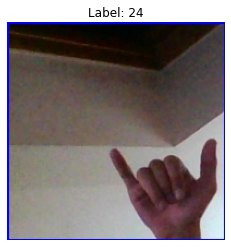

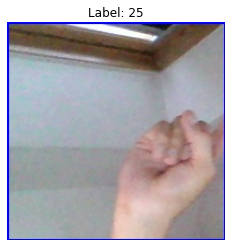

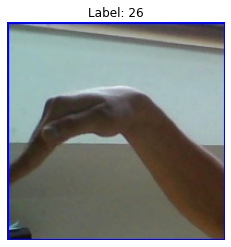

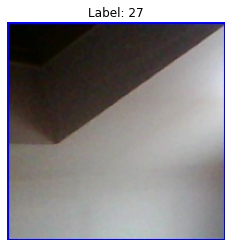

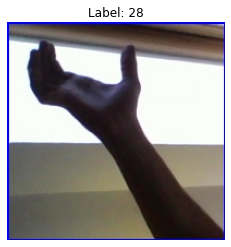

In [102]:
for i in range (0,len(train_dataset),3000):
    image, label = train_dataset[i]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # This hides the axis ticks and labels
    plt.show()

## Default Test Dataset

In [103]:
#for i in range (0,len(test_dataset)):
#    image, label = test_dataset[i]
#    image = transforms.ToPILImage()(image)
#    plt.imshow(image)
#    plt.title(f'Label: {label}')
#    plt.axis('off')  # This hides the axis ticks and labels
#    plt.show()

## Data Loading
### we have two train dataset: one with the skeleton images and one without.

In [104]:
final_test = DataLoader(test_data, batch_size=64, shuffle=False)  
train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)

In [105]:
USE_GPU = True
num_class = 29
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Classification Functions

In [106]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: 
    - A tuple of (final accuracy, iterations, losses) where:
      - final accuracy is the accuracy of the model after the final epoch
      - iterations is a list of iteration numbers
      - losses is a list of losses corresponding to the iterations
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iterations = []
    losses = []
    current_iteration = 0

    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloaderskeleton):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(final_test, model)
                print()

            # Store the current iteration and loss for plotting
            current_iteration += 1
            iterations.append(current_iteration)
            losses.append(loss.item())

    final_accuracy = check_accuracy_part34(final_test, model)
    return final_accuracy, iterations, losses


In [107]:
def check_accuracy_part34(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

## Classification
### This method works well for the default test dataset

In [108]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-3
num_class = 29


In [109]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)

Epoch 0, Iteration 100, loss = 2.1990
Got 1944 / 8700 correct (22.34)

Epoch 0, Iteration 200, loss = 1.6009
Got 3193 / 8700 correct (36.70)



In [ ]:
batchsize = [64,128,256]
channel_1 = 32
channel_2 = 16

for batch_size in batchsize:
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True) 
    test_dataloader2 = DataLoader(dataset, batch_size, shuffle=True)
    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

In [ ]:
learningrate = [1e-2,1e-3,1e-4]
channel_1 = 32
channel_2 = 16

for learning_rate in learningrate:
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True) ## Normal Kaggle test dataset (28 images)
    test_dataloader2 = DataLoader(dataset, batch_size=64, shuffle=True)
#####################################If needing to change NN#####    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                         momentum=0.9, nesterov=True)

###############################################################################
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=1)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

# Varying Hyper Parameters

In [ ]:
train_dataset = CustomImageDataset(
    img_dir= img_directory, 
    transform=train_transform, 
    mode='train'
)
# Calculate the sizes for training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_data, test_data = random_split(train_dataset, [train_size, val_size])
train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)
final_test = DataLoader(test_data, batch_size=64, shuffle=False)  


In [ ]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)

In [ ]:
batchsize = [64,128,256]
channel_1 = 32
channel_2 = 16

for batch_size in batchsize:
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True) 
    test_dataloader2 = DataLoader(dataset, batch_size, shuffle=True)
    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()




# Varying Learning Rate

In [ ]:
learningrate = [1e-2,1e-3,1e-4]
channel_1 = 32
channel_2 = 16

for learning_rate in learningrate:
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True) ## Normal Kaggle test dataset (28 images)
    test_dataloader2 = DataLoader(dataset, batch_size=64, shuffle=True)
#####################################If needing to change NN#####    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                         momentum=0.9, nesterov=True)

###############################################################################
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=1)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

# Experimenting with Channels

In [ ]:
best_batch_size = 64
best_learning_rate = 1e-3

channel_1 = 32
channel_2 = 16

for learning_rate in learningrate:
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True) ## Normal Kaggle test dataset (28 images)
    test_dataloader2 = DataLoader(dataset, batch_size, shuffle=True)
##If needing to change NN #########################   
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


    
##############################################################
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=1)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

# 

# Analysis of Results